In [1]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob

In [62]:
XG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4')
XC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4')
YG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4')
YC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
YC = YC.reshape(2160,2160)
YG = YG.reshape(2160,2160)
XG = XG.reshape(2160,2160)
XC = XC.reshape(2160,2160)
DYG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DXG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DXG = DXG.reshape(2160,2160)
DYG = DYG.reshape(2160,2160)
DYC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DXC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DXC = DXC.reshape(2160,2160)
DYC = DYC.reshape(2160,2160)

In [104]:
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

uvel_merged_l = uvel_merged.isel(time=slice(41-20,41+33+20)).sel(k=8)

vvel_merged_l = vvel_merged.isel(time=slice(41-20,41+33+20)).sel(k=8)

eta_merged_l = eta_merged.isel(time=slice(41-20,41+33+20))

uvel_merged = uvel_merged.isel(time=slice(41,41+33)).sel(k=8)

vvel_merged = vvel_merged.isel(time=slice(41,41+33)).sel(k=8)

eta_merged = eta_merged.isel(time=slice(41,41+33))

uvel_merged = uvel_merged.assign_coords({'x':("i_g", XG[0,:])}).assign_coords({'y':("j", YC[:,0])})

vvel_merged = vvel_merged.assign_coords({'x':("i", XC[0,:])}).assign_coords({'y':("j_g", YG[:,0])})

eta_merged = eta_merged.assign_coords({'x':("i", XC[0,:])}).assign_coords({'y':("j", YC[:,0])})

uvel_merged['time'] = uvel_merged['time']/ np.timedelta64(1, 's')
vvel_merged['time'] = vvel_merged['time']/ np.timedelta64(1, 's')
eta_merged['time'] = eta_merged['time']/ np.timedelta64(1, 's')
uvel_merged_l['time'] = uvel_merged_l['time']/ np.timedelta64(1, 's')
vvel_merged_l['time'] = vvel_merged_l['time']/ np.timedelta64(1, 's')
eta_merged_l['time'] = eta_merged_l['time']/ np.timedelta64(1, 's')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [105]:
def lanczos(x, a):
    return np.sinc(x/a)

In [106]:
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
windowed_u = uvel_merged_l.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
windowed_v = vvel_merged_l.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
windowed_eta = eta_merged_l.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_efiltered = windowed_u.sel(time=uvel_merged.time.values)
v_efiltered = windowed_v.sel(time=vvel_merged.time.values)
eta_efiltered = windowed_eta.sel(time=eta_merged.time.values)

u_efiltered = u_efiltered.assign_coords({'x':("i_g", XG[0,:])}).assign_coords({'y':("j", YC[:,0])})

v_efiltered = v_efiltered.assign_coords({'x':("i", XC[0,:])}).assign_coords({'y':("j_g", YG[:,0])})

eta_efiltered = eta_efiltered.assign_coords({'x':("i", XC[0,:])}).assign_coords({'y':("j", YC[:,0])})

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [107]:
DYG_g_eul = xr.DataArray(DYG, dims=["j", "i_g"],coords=dict(j=(["j"], uvel_merged.j),i_g=(["i_g"], uvel_merged.i_g)))
DXG_g_eul = xr.DataArray(DXG, dims=["j_g", "i"],coords=dict(j=(["j_g"], vvel_merged.j_g),i=(["i"], vvel_merged.i)))
YG_g_eul = xr.DataArray(YG, dims=["j_g", "i"],coords=dict(j=(["j_g"], uvel_merged.j),i_g=(["i"], uvel_merged.i_g)))
YC_g_eul = xr.DataArray(YC, dims=["j", "i_g"],coords=dict(j=(["j"], uvel_merged.j),i_g=(["i_g"], uvel_merged.i_g)))


In [108]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,33):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where(ds.u!=-999)
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_eta = ds.eta.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=2)
        v_piece = windowed_v.sel(time=0).isel(z0=2)
        eta_piece = windowed_eta.sel(time=0).isel(z0=2)
        u_piece2 = ds.u.sel(time=0).isel(z0=2)
        v_piece2 = ds.v.sel(time=0).isel(z0=2)
        eta_piece2 = ds.eta.sel(time=0).isel(z0=2)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        eta_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        eta_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            eta_filtered = eta_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
            eta_unfiltered = eta_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            eta_filtered = xr.concat([eta_filtered,eta_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')
            eta_unfiltered = xr.concat([eta_unfiltered,eta_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

In [109]:
# interpolate onto C-grid
grid2 = Grid(u_filtered, coords={'X': {'center': 'x0', 'left': 'x0_g'}, 'Y': {'center': 'y0', 'left': 'y0_g'}})
u_fil = grid2.interp(u_filtered,'X')
v_fil = grid2.interp(v_filtered,'Y')
u_unfil = grid2.interp(u_unfiltered,'X')
v_unfil = grid2.interp(v_unfiltered,'Y')

YG_g = xr.DataArray(YG, dims=["y0_g", "x0"],coords=dict(j=(["y0_g"], u_fil.y0),i_g=(["x0"], u_fil.x0_g)))
YC_g = xr.DataArray(YC, dims=["y0", "x0_g"],coords=dict(j=(["y0"], u_fil.y0),i_g=(["x0_g"], u_fil.x0_g)))

In [110]:
YC[:,0]

array([-57.001026, -56.989956, -56.978886, ..., -26.694199, -26.677086,
       -26.659971], dtype=float32)

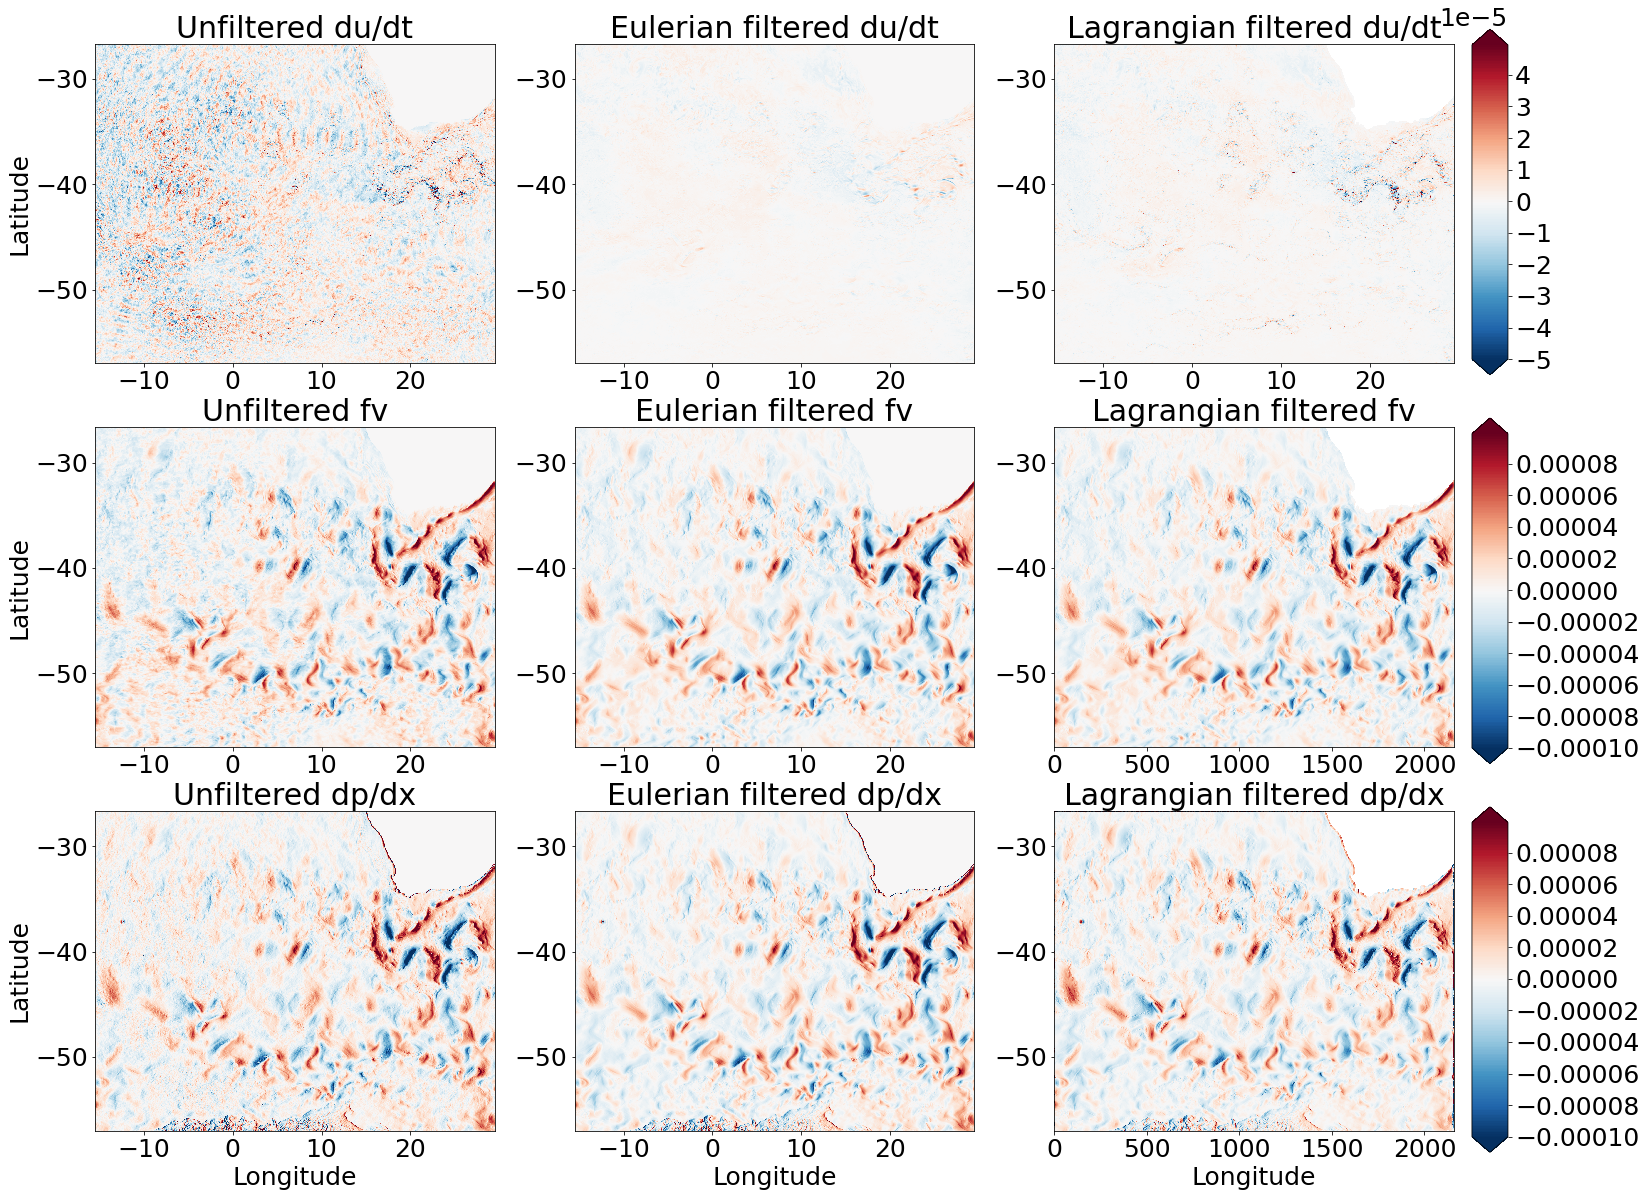

In [119]:
plt.rcParams.update({'font.size': 25})

figure=plt.figure(figsize=(25,20))
plt.subplot(331)
#centered difference differentiation
dudt_eul = uvel_merged.U.chunk({'time':-1}).differentiate('time')
dvdt_eul = vvel_merged.V.chunk({'time':-1}).differentiate('time')
dudt_eul.isel(time=0).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-5*5,add_colorbar=False)
plt.title('Unfiltered du/dt')
plt.xlabel('')
plt.ylabel('Latitude')

plt.subplot(332)
#centered difference differentiation
dudt_ef = u_efiltered.chunk({'time':-1}).differentiate('time')
dvdt_ef = v_efiltered.chunk({'time':-1}).differentiate('time')
dudt_ef.isel(time=0).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-5*5,add_colorbar=False)
plt.title('Eulerian filtered du/dt')
plt.xlabel('')
plt.ylabel('')

plt.subplot(333)
#centered difference differentiation
dudt_f = u_filtered.chunk({'time':-1}).differentiate('time')
dvdt_ef = v_filtered.chunk({'time':-1}).differentiate('time')
cs1 = dudt_f.isel(time=0).plot(x='x0',y='y0',levels=np.arange(-1,1,0.01)*10**-5*5,add_colorbar=False)
plt.title('Lagrangian filtered du/dt')
plt.xlabel('')
plt.ylabel('')

plt.subplot(334)
fG = 2*2*np.pi/24/3600*np.sin(YG_g_eul*np.pi/180)
fC = 2*2*np.pi/24/3600*np.sin(YC_g_eul*np.pi/180)
fu = grid.interp(grid.interp(uvel_merged.U,'X'),'Y')*fG
fv = grid.interp(grid.interp(vvel_merged.V,'X'),'Y')*fC
fv = fv.assign_coords({'x':("i_g", XG[0,:])}).assign_coords({'y':("j", YC[:,0])})
fv.isel(time=0).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('Unfiltered fv')
plt.xlabel('')
plt.ylabel('Latitude')

plt.subplot(335)
fG = 2*2*np.pi/24/3600*np.sin(YG_g_eul*np.pi/180)
fC = 2*2*np.pi/24/3600*np.sin(YC_g_eul*np.pi/180)
fu = grid.interp(grid.interp(u_efiltered,'X'),'Y')*fG
fv = grid.interp(grid.interp(v_efiltered,'X'),'Y')*fC
fv = fv.assign_coords({'x':("i_g", XG[0,:])}).assign_coords({'y':("j", YC[:,0])})
fv.isel(time=0).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('Eulerian filtered fv')
plt.xlabel('')
plt.ylabel('')


fG = 2*2*np.pi/24/3600*np.sin(YG_g*np.pi/180)
fC = 2*2*np.pi/24/3600*np.sin(YC_g*np.pi/180)
fu_un = grid2.interp(grid2.interp(u_unfil,'X'),'Y')*fG
fv_un = grid2.interp(grid2.interp(v_unfil,'X'),'Y')*fC
fu_f = grid2.interp(grid2.interp(u_fil,'X'),'Y')*fG
fv_f = grid2.interp(grid2.interp(v_fil,'X'),'Y')*fC

plt.subplot(336)
cs2 = fv_f.isel(time=0).plot(x='x0_g',y='y0',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('Lagrangian filtered fv')
plt.xlabel('')
plt.ylabel('')


plt.subplot(337)
detadx = grid.diff(9.81*eta_merged.Eta,'X')/DXC
detady = grid.diff(9.81*eta_merged.Eta,'Y')/DYC
detadx = detadx.assign_coords({'x':("i_g", XG[0,:])}).assign_coords({'y':("j", YC[:,0])})
detadx.isel(time=0).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('Unfiltered dp/dx')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(338)
detadx = grid.diff(9.81*eta_efiltered,'X')/DXC
detady = grid.diff(9.81*eta_efiltered,'Y')/DYC
detadx = detadx.assign_coords({'x':("i_g", XG[0,:])}).assign_coords({'y':("j", YC[:,0])})
detadx.isel(time=0).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('Eulerian filtered dp/dx')
plt.xlabel('Longitude')
plt.ylabel('')

plt.subplot(339)
detadx_f = grid2.diff(9.81*eta_filtered,'X')/DXC
detady_f = grid2.diff(9.81*eta_filtered,'Y')/DYC
detadx = detadx.assign_coords({'x0':("i_g", XG[0,:])})
cs3 = detadx_f.isel(time=0).plot(x='x0_g',y='y0',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('Lagrangian filtered dp/dx')
plt.xlabel('Longitude')
plt.ylabel('')

fig=plt.gcf()
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.89, 0.65, 0.02, 0.24])
fig.colorbar(cs1, cax=cbar_ax)

cbar_ax = fig.add_axes([0.89, 0.38, 0.02, 0.24])
fig.colorbar(cs2, cax=cbar_ax)

cbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.24])
fig.colorbar(cs3, cax=cbar_ax)

fig.savefig('momentum.png')

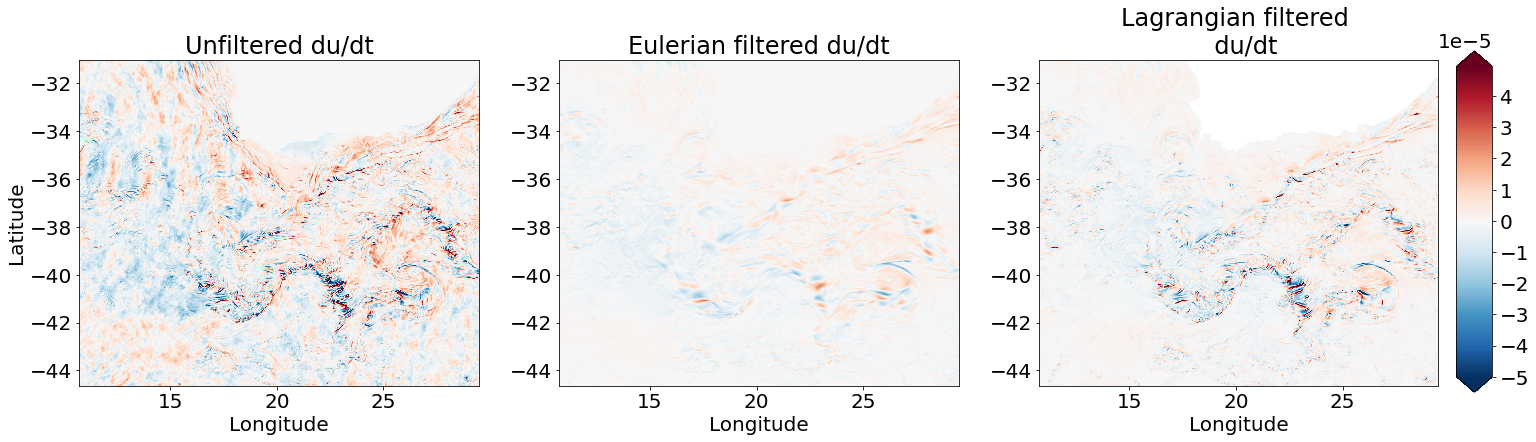

In [133]:
plt.rcParams.update({'font.size': 20})

figure=plt.figure(figsize=(25,6))
plt.subplot(131)
#centered difference differentiation
dudt_eul = uvel_merged.U.chunk({'time':-1}).differentiate('time')
dvdt_eul = vvel_merged.V.chunk({'time':-1}).differentiate('time')
dudt_eul.isel(time=0,i_g=slice(1260,3000),j=slice(1000,1900)).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-5*5,add_colorbar=False)
plt.title('Unfiltered du/dt')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(132)
#centered difference differentiation
dudt_ef = u_efiltered.chunk({'time':-1}).differentiate('time')
dvdt_ef = v_efiltered.chunk({'time':-1}).differentiate('time')
dudt_ef.isel(time=0,i_g=slice(1260,3000),j=slice(1000,1900)).plot(x='x',y='y',levels=np.arange(-1,1,0.01)*10**-5*5,add_colorbar=False)
plt.title('Eulerian filtered du/dt')
plt.xlabel('Longitude')
plt.ylabel('')

plt.subplot(133)
#centered difference differentiation
dudt_f = u_filtered.chunk({'time':-1}).differentiate('time')
dvdt_ef = v_filtered.chunk({'time':-1}).differentiate('time')
cs1 = dudt_f.isel(time=0,x0=slice(1260,3000),y0=slice(1000,1900)).plot(x='x0',y='y0',levels=np.arange(-1,1,0.01)*10**-5*5,add_colorbar=False)
plt.title('Lagrangian filtered \n  du/dt')
plt.xlabel('Longitude')
plt.ylabel('')

fig=plt.gcf()
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.79])
fig.colorbar(cs1, cax=cbar_ax)

fig.savefig('momentum_zoom.png')

In [120]:
dudt_eul

<xarray.DataArray 'U' (time: 33, j: 2160, i_g: 2160)>
dask.array<_trim, shape=(33, 2160, 2160), dtype=float32, chunksize=(33, 540, 540), chunktype=numpy.ndarray>
Coordinates:
    face     int64 ...
  * i_g      (i_g) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(33,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    k        int64 8
  * time     (time) float64 4.032e+05 4.068e+05 ... 5.148e+05 5.184e+05
    x        (i_g) >f4 dask.array<chunksize=(2160,), meta=np.ndarray>
    y        (j) >f4 dask.array<chunksize=(2160,), meta=np.ndarray>